In [2]:
%matplotlib inline
from pylab import *

In [3]:
import my.manglers.fx as fx
dfx = fx.get_reasonable_fred_daily_rates()

read_parquet /home/cottrell/projects/data/extractors/pdr/fred_meta_rate_daily/
... took 0.006912708282470703 seconds
read_parquet /home/cottrell/projects/data/extractors/pdr/fred/
... took 0.14601731300354004 seconds
coalescing to latest by ['symbol', 'date']
df.shape = (1689574, 4) (before)
df.shape = (1689574, 3) (after)
... took 0.4409208297729492 seconds


In [4]:
import my.manglers.equities as eq
reload(eq)
df = eq.get_open_oriented_view()
df.symbol.cat.remove_unused_categories(inplace=True)
df.symbol.value_counts()

read_parquet /home/cottrell/projects/data/extractors/pdr/yahoo_price_volume/0
... took 1.4841654300689697 seconds
coalescing to latest by ['symbol', 'date']
df.shape = (58218, 12) (before)
df.shape = (50605, 11) (after)
... took 0.015466928482055664 seconds


noc     7443
xom     7440
ibm     7440
ge      7440
gs      5081
a       4942
goog    3750
v       2849
cit     2412
fb      1808
Name: symbol, dtype: int64

In [5]:
df.date.describe()

count                   50605
unique                   7453
top       2012-08-23 00:00:00
freq                       10
first     1990-01-02 00:00:00
last      2019-07-26 00:00:00
Name: date, dtype: object

In [52]:
d = df.set_index(['symbol', 'date']).sort_index()

In [54]:
# try almost no engineering!

dd = np.log(d).dropna().loc['ibm'] # .reset_index('symbol')

train_end = '2016-01-01'
d_train = dd.loc[:train_end]
d_test = dd.loc[train_end:]
d_train.head()

target = ['high']
cols = ['open', 'open_lag1', 'low_lag1', 'high_lag1', 'close_lag1']

def get_xy_from_df(df, cols=cols, target=target, dtype=np.float32):
    x = tf.convert_to_tensor(d_train[cols].values.astype(dtype))
    y = tf.squeeze(tf.convert_to_tensor(d_train[target].values.astype(dtype)))
    return x, y

In [55]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

class GPRMatern(tf.keras.models.Model):
    def __init__(self, feature_ndims=1):
        super().__init__()
        self.kernel = psd_kernels.MaternFiveHalves()
        self.observation_noise_variance = tf.Variable(np.float32(.01), name='obs_noise_variance')

    def gprm(self, x_obs, y_obs, x):
        return tfd.GaussianProcessRegressionModel(
            kernel=self.kernel,
            index_points=x,
            observation_index_points=x_obs,
            observations=y_obs,
            observation_noise_variance=self.observation_noise_variance)

    def nll_for_train(self, x_obs, y_obs):
        gp = tfd.GaussianProcess(
            kernel=self.kernel,
            index_points=x_obs,
            observation_noise_variance=self.observation_noise_variance)
        return -tf.reduce_mean(gp.log_prob(y_obs))

class GPRExpQuad(tf.keras.models.Model):
    def __init__(self, mydtype=np.float64):
        self.mydtype = mydtype
        super().__init__()
        self.amplitude_ = tf.Variable(self.mydtype(0.0), name='amplitude')
        self.length_scale_ = tf.Variable(self.mydtype(0.0), name='length_scale')
        self.observation_noise_variance_ = tf.Variable(self.mydtype(-5.0), name='obs_noise_variance')

    @property
    def kernel(self):
        return psd_kernels.ExponentiatedQuadratic(self.amplitude, self.length_scale)

    @property
    def amplitude(self):
        return np.finfo(self.mydtype).tiny + tf.math.softplus(self.amplitude_)

    @property
    def length_scale(self):
        return np.finfo(self.mydtype).tiny + tf.math.softplus(self.length_scale_)

    @property
    def observation_noise_variance(self):
        return np.finfo(self.mydtype).tiny + tf.math.softplus(self.observation_noise_variance_)

    def nll_for_train(self, x_obs, y_obs):
        gp = tfd.GaussianProcess(
            kernel=self.kernel,
            index_points=x_obs,
            observation_noise_variance=self.observation_noise_variance)
        return -tf.reduce_mean(gp.log_prob(y_obs))

    def gprm(self, x_obs, y_obs, x):
        return tfd.GaussianProcessRegressionModel(
            kernel=self.kernel,
            index_points=x,
            observation_index_points=x_obs,
            observations=y_obs,
            observation_noise_variance=self.observation_noise_variance)

def test_model(model=GPRMatern):
    model = model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    # model.fit(x, y, epochs=steps)
    for i in range(10):
        with tf.GradientTape() as tape:
            l = model.nll_for_train(x, y)
        g = tape.gradient(l, model.trainable_variables)
        optimizer.apply_gradients(zip(g, model.trainable_variables))
        print({x.name: x.numpy() for x in model.trainable_variables})

matern = GPRMatern()
expquad = GPRExpQuad()

In [56]:
dtype = np.float64
x_train, y_train = get_xy_from_df(d_train, dtype=dtype)
x_test, y_test = get_xy_from_df(d_test, dtype=dtype)
model = GPRExpQuad(mydtype=dtype)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def get_batch(x_train, y_train, batch_size):
    i = np.random.permutation(x_train.shape[0])[:batch_size]
    return tf.gather(x_train, i), tf.gather(y_train, i)

@tf.function
def train_one(x_train, y_train):
    with tf.GradientTape() as tape:
        loss = model.nll_for_train(x_train, y_train)
    g = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(g, model.trainable_variables))
    d = dict(loss=loss)
    d.update({x.name: x for x in model.trainable_variables})
    return d

def train(n=1000, batch_size=1024, batch_period=10, stats_period=10):
    out = list()
    for i in range(n):
        if i % batch_period == 0:
            x, y = get_batch(x_train, y_train, batch_size=batch_size)
            d = train_one(x, y)
            if i % stats_period == 0:
                d = {k: v.numpy() for k, v in d.items()}
                print(i, d)
            out.append(d)
    return pd.DataFrame(out)

In [58]:
train_out = train()

0 {'loss': -1472.9735156035713, 'amplitude:0': 0.09999999794600145, 'length_scale:0': 0.09999999748347148, 'obs_noise_variance:0': -5.100000000841215}
10 {'loss': -1535.4190925680657, 'amplitude:0': 0.19847982390529154, 'length_scale:0': 0.1996513633585064, 'obs_noise_variance:0': -5.199996067484359}
20 {'loss': -1597.1155783515164, 'amplitude:0': 0.29447356801092994, 'length_scale:0': 0.2984832673920008, 'obs_noise_variance:0': -5.2999880381500954}
30 {'loss': -1656.0570933444596, 'amplitude:0': 0.3872710894306452, 'length_scale:0': 0.39642461011844143, 'obs_noise_variance:0': -5.399975887212617}
40 {'loss': -1712.6195588717164, 'amplitude:0': 0.47632147210789255, 'length_scale:0': 0.4932084019415634, 'obs_noise_variance:0': -5.499954975248913}
50 {'loss': -1770.4000642099209, 'amplitude:0': 0.5610464429312677, 'length_scale:0': 0.5887561999012957, 'obs_noise_variance:0': -5.599939200279022}
60 {'loss': -1821.2198941006236, 'amplitude:0': 0.6412008619321546, 'length_scale:0': 0.682958

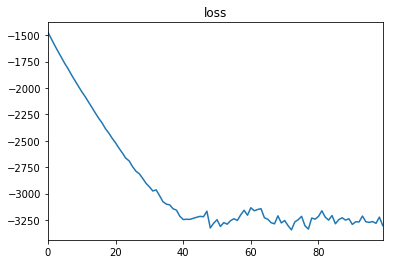

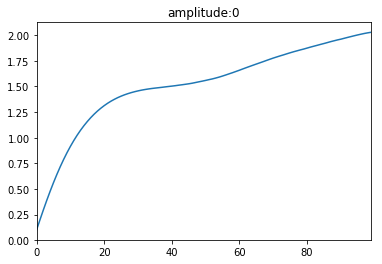

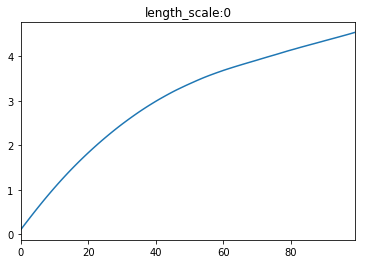

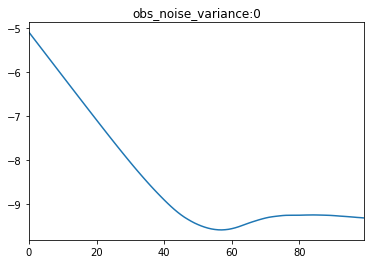

In [60]:
for k in train_out:
    figure()
    train_out[k].plot()
    title(k)

In [77]:
import tqdm
def get_pred(x, y, window=100):
    yp = list()
    for i in tqdm.tqdm(range(0, x.shape[0] - window - 1)):
        x_ = x[:(i + window)]
        y_ = y[:(i + window)]
        x_new = x[(i + window):(i + window + 1)]
        y_pred = model.gprm(x_, y_, x_new)
        yp.append([y_pred.mean(), y_pred.stddev()])
    return y[1+window:].numpy(), np.array(yp)

In [78]:
x, y = get_batch(x_train, y_train, 1024)
yr, yp = get_pred(x, y)

100%|██████████| 923/923 [00:45<00:00, 12.90it/s]


In [80]:
yr.shape, yp.shape

(TensorShape([923]), (923, 2))

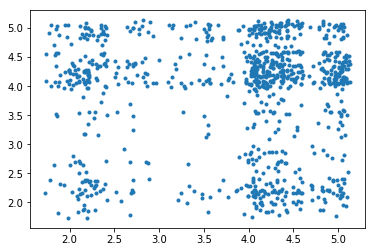

In [87]:
plot(yr, yp[:,0], '.')

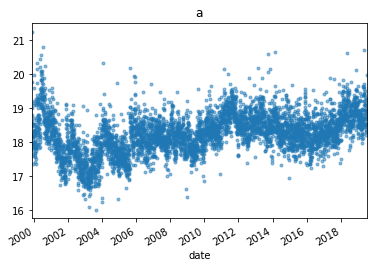

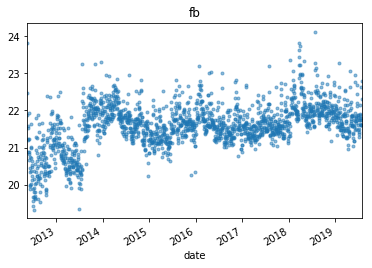

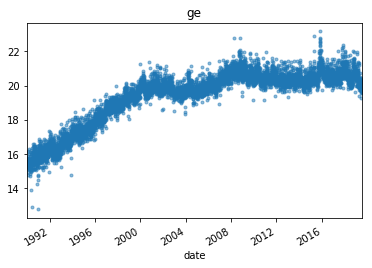

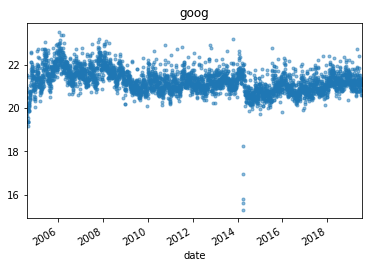

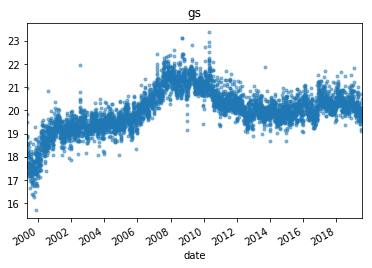

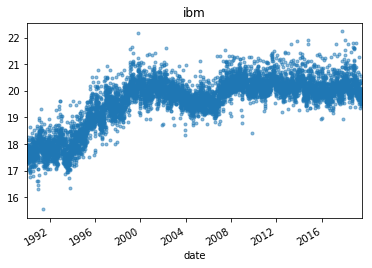

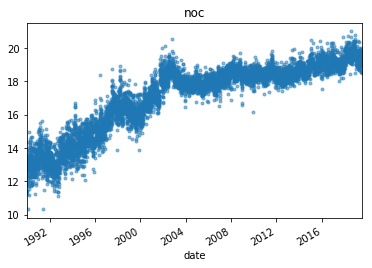

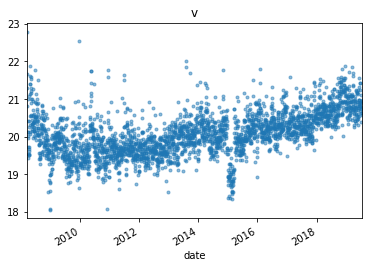

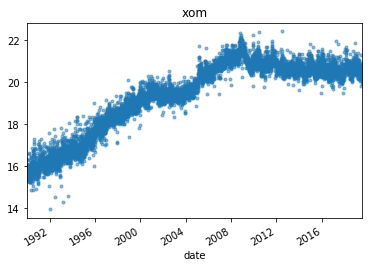

In [263]:
for k, v in d.groupby(level='symbol'):
    figure()
    x = v.loc[k]
    s = np.log(x['volume'] * x['close'])
    s.plot(style='.', alpha=0.5)
    title(k)

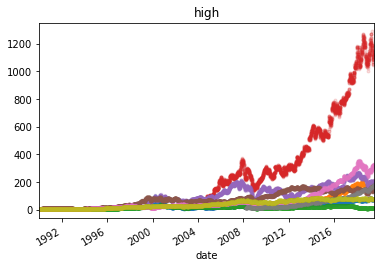

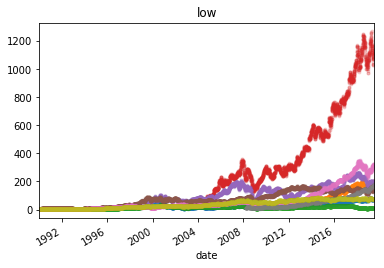

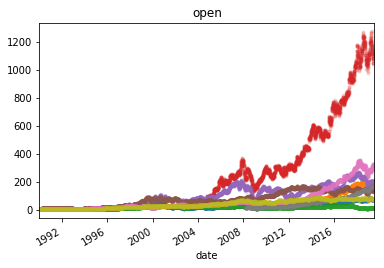

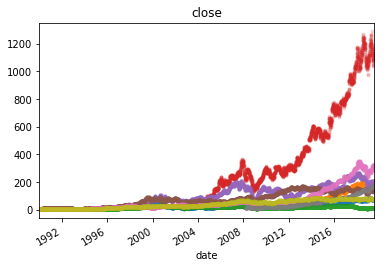

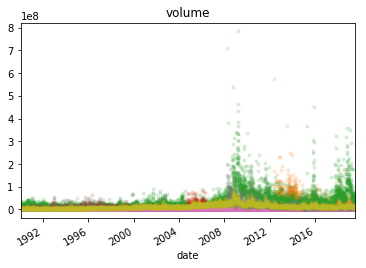

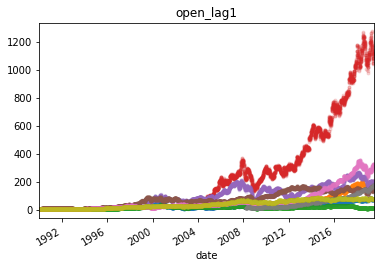

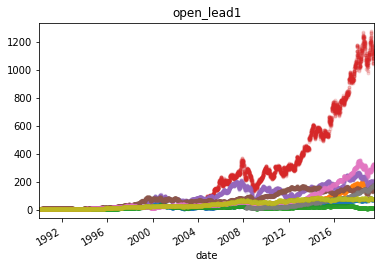

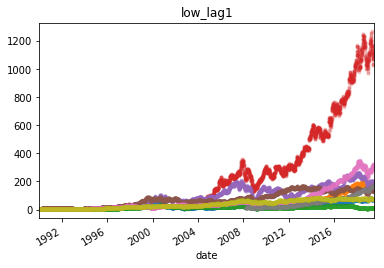

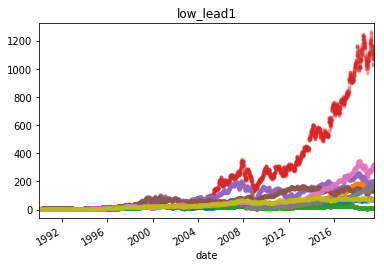

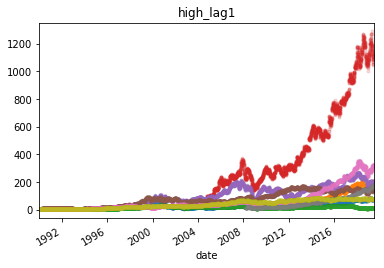

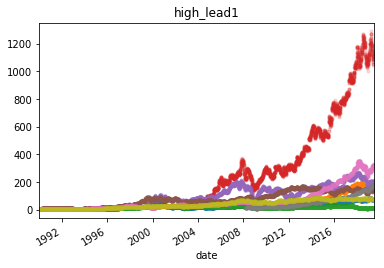

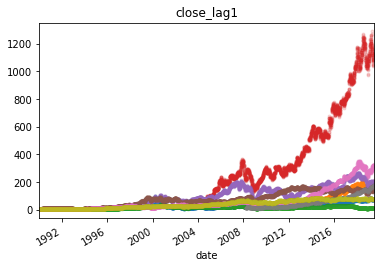

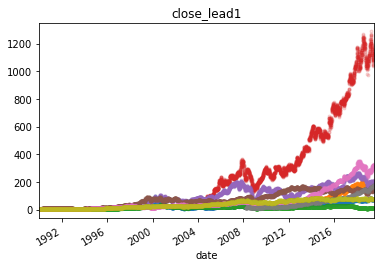

In [261]:
for k, v in d.groupby(level='symbol'):
    for i, kk in enumerate(v.columns):
        figure(i)
        v.loc[k][kk].plot(style='.', alpha=0.15)
        title(kk)

In [ ]:
target = ['open_to_']
cols = [
#  'high',
#  'low',
#  'open',
#  'close',
#  'volume',
#  'adj close',
#  'dividends',
#  'splits',
#  'product',
#  'symbol',
 'log_volume',
 'open_to_close',
 'open_equal_high',
 'open_equal_low',
 'open_to_high',
 'open_to_low',
 'close_to_open']

In [88]:
df.close.mad()

97.398660770118

In [108]:
d = df.set_index(['date', 'symbol'])[cols + target].unstack('symbol')
d = d.stack('symbol')
d.index = d.index.reorder_levels([1, 0])
d = d.sort_index()
d = d.astype(np.float32)

KeyError: "['high0'] not in index"

In [95]:
d.describe()

,log_volume,open_to_close,open_equal_high,open_equal_low,open_to_high,open_to_low,close_to_open
count,37889.000000,37889.000000,37889.000000,37889.000000,37889.000000,37889.000000,37889.000000
mean,15.443321,0.000198,0.053710,0.055188,-5.633967,-5.674733,0.000139
std,1.397553,0.017140,0.225447,0.228349,3.224263,3.265553,0.011005
min,8.974618,-0.313390,0.000000,0.000000,-18.420681,-18.420681,-0.218042
25%,14.622343,-0.007725,0.000000,0.000000,-5.683742,-5.746505,-0.003390
50%,15.397022,0.000000,0.000000,0.000000,-4.848795,-4.885370,0.000000
75%,16.383341,0.008269,0.000000,0.000000,-4.206538,-4.212109,0.003745
max,20.478670,0.341516,1.000000,1.000000,-1.021072,-1.160305,0.277281


In [96]:
d.head()

log_volume  open_to_close  open_equal_high  open_equal_low  open_to_high  open_to_low  close_to_open
symbol date                                                                                                            
a      1999-11-18   17.951418      -0.033523              0.0             0.0     -2.361160    -2.049239      -0.024444
       1999-11-19   16.539047      -0.061535              0.0             0.0     -6.533063    -2.582767       0.022954
       1999-11-22   15.699211       0.063025              0.0             0.0     -2.764231    -3.482698      -0.034686
       1999-11-23   15.603195      -0.060625              0.0             0.0     -3.644811    -2.803054       0.003120
       1999-11-24   15.393086       0.023096              0.0             0.0     -3.119465    -5.769866      -0.004577

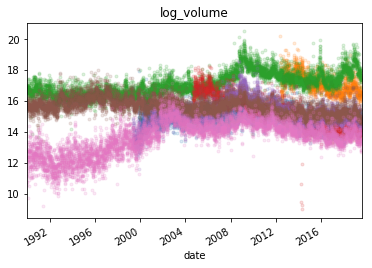

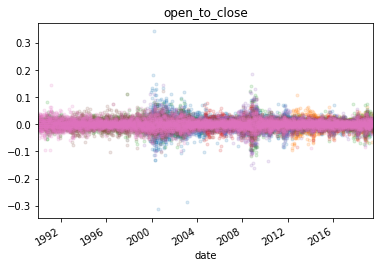

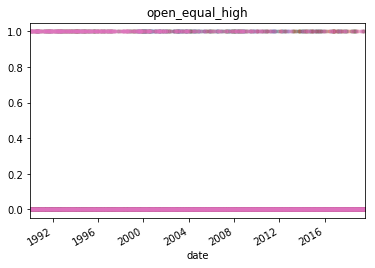

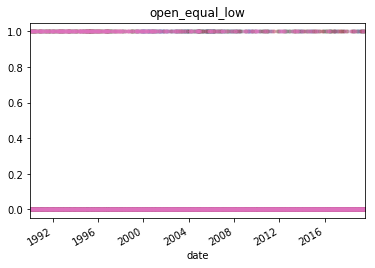

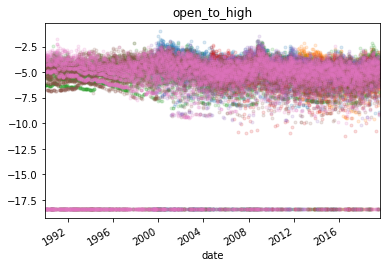

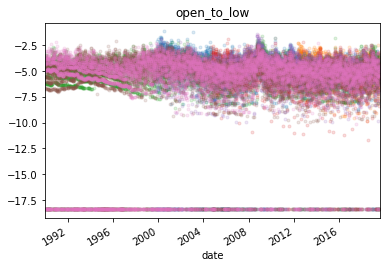

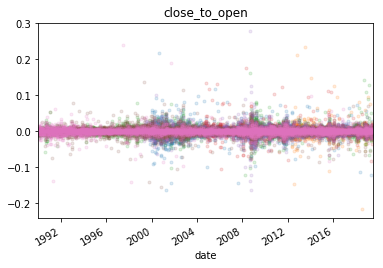

In [100]:
for k, v in d.groupby(level='symbol'):
    for i, kk in enumerate(v.columns):
        figure(i)
        v.loc[k][kk].plot(style='.', alpha=0.15)
        title(kk)

In [107]:
dd = d.reset_index('symbol')
train_end = '2016-01-01'
d_train = dd.loc[:train_end]
d_test = dd.loc[train_end:]



,symbol,log_volume,open_to_close,open_equal_high,open_equal_low,open_to_high,open_to_low,close_to_open
date,,,,,,,,
1999-11-18,a,17.951418,-0.033523,0.0,0.0,-2.361160,-2.049239,-0.024444
1999-11-19,a,16.539047,-0.061535,0.0,0.0,-6.533063,-2.582767,0.022954
1999-11-22,a,15.699211,0.063025,0.0,0.0,-2.764231,-3.482698,-0.034686
1999-11-23,a,15.603195,-0.060625,0.0,0.0,-3.644811,-2.803054,0.003120
1999-11-24,a,15.393086,0.023096,0.0,0.0,-3.119465,-5.769866,-0.004577


In [36]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
X = tfd.LogNormal(loc=0.0100, 0.0250)